# Process data

In [5]:
import pandas as pd
import numpy as np

In [6]:
df_messanger = pd.read_csv("mainTable_fpkm.csv", index_col=0)
df_miRNA = pd.read_csv("mainTable_miRNA.csv", index_col=0)

In [7]:
df_files = pd.read_csv("files_manifest.dat")

In [8]:
df_files.drop_duplicates(subset=["file_fpkm"], keep="first", inplace=True)
df_files.drop_duplicates(subset=["file_miRNA"], keep="first", inplace=True)

In [9]:
df_files.set_index("file_fpkm", inplace=True)
df_files = df_files.reindex(index=df_messanger.columns).dropna(how="all", axis=0)
df_messanger = df_messanger.reindex(columns=df_files.index)
df_messanger.columns = df_files["cases.0.submitter_id"]
df_messanger.head(2)

cases.0.submitter_id,TCGA-D8-A140,TCGA-BH-A0BA,TCGA-AR-A5QQ,TCGA-D8-A3Z5,TCGA-AC-A5XS,TCGA-E2-A14Z,TCGA-LL-A442,TCGA-AC-A3QP,TCGA-PE-A5DE,TCGA-E9-A24A,...,TCGA-AN-A0FV,TCGA-D8-A73X,TCGA-A7-A13E,TCGA-A8-A0A2,TCGA-D8-A1XL,TCGA-A7-A0D9,TCGA-AR-A0U2,TCGA-E2-A158,TCGA-E9-A247,TCGA-B6-A0X4
0,,,,,,,,,,,,,,,,,,,,,
ENSG00000000419,27.44,47.07,41.19,18.94,51.19,28.25,26.33,27.71,36.63,31.80,...,29.81,31.71,47.60,25.05,49.08,62.29,41.62,36.36,53.22,25.96
ENSG00000000457,6.07,10.84,1.20,6.18,4.47,3.63,3.42,3.13,7.07,6.45,...,7.88,7.34,7.83,8.21,4.58,4.89,5.89,5.26,3.92,5.04


In [10]:
df_files = df_files.reset_index().set_index("file_miRNA")
df_files = df_files.reindex(index=df_miRNA.columns).dropna(how="all", axis=0)
df_miRNA = df_miRNA.reindex(columns=df_files.index)
df_miRNA.columns = df_files["cases.0.submitter_id"]
df_miRNA.head(2)

cases.0.submitter_id,TCGA-B6-A0RG,TCGA-OL-A5RW,TCGA-A2-A25C,TCGA-AR-A1AT,TCGA-AC-A3EH,TCGA-EW-A1J6,TCGA-A7-A3J0,TCGA-BH-A202,TCGA-A1-A0SO,TCGA-B6-A0X7,...,TCGA-AQ-A04H,TCGA-BH-A0HB,TCGA-A2-A0EY,TCGA-AC-A2QI,TCGA-E9-A3Q9,TCGA-AO-A03R,TCGA-AN-A0FS,TCGA-B6-A0RM,TCGA-A2-A0CO,TCGA-A8-A09Z
miRNA_ID,,,,,,,,,,,,,,,,,,,,,
hsa-let-7a-1,20703,32828,6626,32121,17163,17838,73618,19923,4264,6914,...,18300,8883,7266,472620,70117,31438,27072,21912,128843,13180
hsa-let-7a-2,20393,33168,6655,32285,16883,17654,73382,19672,4242,6927,...,18393,8773,7487,471007,69523,31063,26741,21377,127938,12914


In [11]:
df = df_messanger.append(df_miRNA.reindex(columns=df_messanger.columns))
df.to_csv("mainTable_all.csv", index=True)

In [12]:
df

cases.0.submitter_id,TCGA-D8-A140,TCGA-BH-A0BA,TCGA-AR-A5QQ,TCGA-D8-A3Z5,TCGA-AC-A5XS,TCGA-E2-A14Z,TCGA-LL-A442,TCGA-AC-A3QP,TCGA-PE-A5DE,TCGA-E9-A24A,...,TCGA-AN-A0FV,TCGA-D8-A73X,TCGA-A7-A13E,TCGA-A8-A0A2,TCGA-D8-A1XL,TCGA-A7-A0D9,TCGA-AR-A0U2,TCGA-E2-A158,TCGA-E9-A247,TCGA-B6-A0X4
ENSG00000000419,27.44,47.07,41.19,18.94,51.19,28.25,26.33,27.71,36.63,31.80,...,29.81,31.71,47.60,25.05,49.08,62.29,41.62,36.36,53.22,25.96
ENSG00000000457,6.07,10.84,1.20,6.18,4.47,3.63,3.42,3.13,7.07,6.45,...,7.88,7.34,7.83,8.21,4.58,4.89,5.89,5.26,3.92,5.04
ENSG00000000460,2.10,6.43,2.16,1.62,3.29,2.84,1.28,1.03,2.56,2.10,...,1.28,2.85,4.93,2.12,2.76,1.12,5.39,2.27,2.81,0.90
ENSG00000000938,1.65,1.84,5.48,2.18,3.20,5.97,7.89,3.10,7.17,2.93,...,1.20,3.22,1.29,2.09,2.53,1.05,1.96,0.75,1.08,0.37
ENSG00000000971,5.13,6.38,6.98,4.22,7.89,6.73,1.14,5.83,7.88,8.54,...,4.33,3.94,4.68,4.97,3.47,3.73,4.11,1.10,3.20,0.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hsa-mir-9500,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
hsa-mir-96,202.00,28.00,42.00,581.00,793.00,5.00,486.00,202.00,319.00,51.00,...,50.00,492.00,81.00,57.00,41.00,3.00,76.00,182.00,484.00,199.00
hsa-mir-98,147.00,41.00,209.00,189.00,562.00,137.00,313.00,568.00,239.00,205.00,...,34.00,284.00,134.00,105.00,130.00,56.00,41.00,355.00,161.00,135.00
hsa-mir-99a,2177.00,1190.00,699.00,4116.00,4096.00,591.00,238.00,21316.00,932.00,1007.00,...,409.00,10615.00,1506.00,1064.00,189.00,3063.00,217.00,932.00,3703.00,119.00


In [13]:
df_files = df_files.reset_index().set_index("cases.0.submitter_id")

In [14]:
df_files = df_files.reset_index().set_index("cases.0.samples.0.portions.0.analytes.0.aliquots.0.submitter_id.1")

In [15]:
df_biolinks = pd.read_csv("TCGA_biolinks.csv", index_col=0)
df_biolinks = df_biolinks[df_biolinks["cancer.type"]=="BRCA"]
df_biolinks.set_index("pan.samplesID", inplace=True)

In [16]:
df_files = df_files.join(df_biolinks).dropna(how="all", axis=1).reset_index().set_index("cases.0.submitter_id")
df_files = df_files.reindex(index=df.columns).dropna(how="all", axis=0)
df_files.to_csv("files.dat")
df_files.head(2)

,cases.0.samples.0.portions.0.analytes.0.aliquots.0.submitter_id.1,level_0,index,cases.0.diagnoses.0.morphology,cases.0.diagnoses.0.primary_diagnosis,cases.0.diagnoses.0.tissue_or_organ_of_origin,cases.0.diagnoses.0.tumor_grade,cases.0.diagnoses.0.tumor_stage,cases.0.project.disease_type,cases.0.project.primary_site,...,cases.0.diagnoses.0.morphology.1,cases.0.diagnoses.0.primary_diagnosis.1,cases.0.diagnoses.0.tissue_or_organ_of_origin.1,cases.0.diagnoses.0.tumor_grade.1,cases.0.diagnoses.0.tumor_stage.1,cases.0.project.disease_type.1,cases.0.project.primary_site.1,cancer.type,Subtype_mRNA,Subtype_Selected
cases.0.submitter_id,,,,,,,,,,,,,,,,,,,,,
TCGA-D8-A140,TCGA-D8-A140-01A-11R-A115-07,67414fe8-5dfa-49e0-a3a9-a696a15be65f.mirbase21...,1c072d05-bdd8-4d30-ba1d-099ed32ea33a.FPKM.txt.gz,8500/3,"Infiltrating duct carcinoma, NOS","Breast, NOS",not reported,stage iib,Breast Invasive Carcinoma,Breast,...,8500/3,"Infiltrating duct carcinoma, NOS","Breast, NOS",not reported,stage iib,Breast Invasive Carcinoma,Breast,BRCA,LumA,BRCA.LumA
TCGA-BH-A0BA,TCGA-BH-A0BA-01A-11R-A056-07,97fb1d84-7fa0-4fa9-b5ed-c370cb774c6f.mirbase21...,5c0f9cb8-cc53-49ce-8384-6acb54cb1855.FPKM.txt.gz,8522/3,Infiltrating duct and lobular carcinoma,"Breast, NOS",not reported,stage iiic,Breast Invasive Carcinoma,Breast,...,8522/3,Infiltrating duct and lobular carcinoma,"Breast, NOS",not reported,stage iiic,Breast Invasive Carcinoma,Breast,BRCA,LumA,BRCA.LumA


# Filter genes
## HVG

In [17]:
import scanpy as sc

In [18]:
adata = sc.AnnData(X=df.reindex(columns=df_files.index).dropna(how="all", axis=1).transpose(), obs=df_files)

In [19]:
sc.pp.log1p(adata, copy=False)
sc.pp.highly_variable_genes(adata, n_top_genes=3000, n_bins=50)

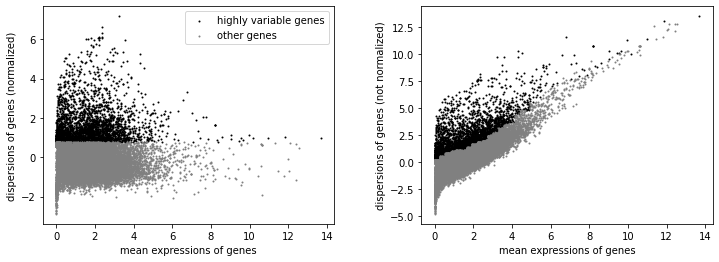

In [20]:
sc.pl.highly_variable_genes(adata, log=False, save='hvg.pdf')

In [21]:
hvg = adata.var[adata.var['highly_variable']==True].index
samples = adata.obs.index

In [22]:
hvg

Index(['ENSG00000001561', 'ENSG00000002933', 'ENSG00000003249',
       'ENSG00000003436', 'ENSG00000003989', 'ENSG00000004776',
       'ENSG00000004799', 'ENSG00000004838', 'ENSG00000005243',
       'ENSG00000005249',
       ...
       'hsa-mir-935', 'hsa-mir-937', 'hsa-mir-938', 'hsa-mir-939',
       'hsa-mir-940', 'hsa-mir-941-1', 'hsa-mir-942', 'hsa-mir-943',
       'hsa-mir-944', 'hsa-mir-95'],
      dtype='object', length=2999)

In [ ]:
df.reindex(index=hvg, columns=samples).to_csv("mainTable_hv.csv")

# Make Graph

In [186]:
import graph_tool.all as gt
from time import time

In [202]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../trisbm")

from trisbm import trisbm

In [205]:
model = trisbm()
model.make_graph(df.reindex(index=hvg), get_kind=lambda word: 1 if "ENSG" in word else 0)

In [206]:
g = model.g
g

<Graph object, undirected, with 3789 vertices and 1872907 edges, 2 internal vertex properties, 1 internal edge property, at 0x7f0f20646c40>

In [97]:
g.save("graph_hv_tri_log.xml.gz")
g=gt.load_graph("graph_hv_tri_log.xml.gz")
g

<Graph object, undirected, with 3789 vertices and 1872907 edges, 2 internal vertex properties, 1 internal edge property, at 0x7f0f192a5e50>

<AxesSubplot:>

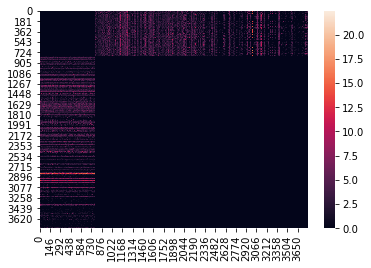

In [207]:
sns.heatmap(gt.adjacency(g, weight=g.ep["count"]).toarray())

In [73]:
np.log2(df["TCGA-D8-A140"]["ENSG00000000938"]+1)

1.4059923596758368

In [22]:
clabel = g.vp['kind']
state_args = {'clabel': clabel, 'pclabel': clabel}
state_args["eweight"] = g.ep.count

In [24]:
state = gt.NestedBlockState(g)

In [ ]:
state = gt.minimize_nested_blockmodel_dl(g, 
                                deg_corr=True,
                                overlap=False,
                                state_args=state_args,
                                mcmc_args={'sequential': False},
                                mcmc_equilibrate_args={'mcmc_args': {'sequential': False}},
                                mcmc_multilevel_args={
                                      'mcmc_equilibrate_args': {
                                          'mcmc_args': {'sequential': False}
                                      },
                                      'anneal_args': {
                                          'mcmc_equilibrate_args': {
                                               'mcmc_args': {'sequential': False}
                                          }
                                      }
                                  },
                                verbose=True)

In [ ]:
for _ in range(100):
    state.multiflip_mcmc_sweep(beta=np.inf, niter=10, verbose=True)

level: 15
level: 1
level: 6
level: 8
level: 7
level: 12
level: 10
level: 2
level: 13
level: 4
level: 0


In [ ]:
state.draw(subsample_edges=1000)

## sbmtm

In [ ]:
import sys
sys.path.append("../hSBM_Topicmodel/")

In [ ]:
from sbmtm import sbmtm

In [ ]:
model = sbmtm()
model.make_graph_from_BoW_df(df.reindex(index=hvg).dropna(how="any", axis=1))
model.save_graph("graph_hv.xml.gz")

### log

In [ ]:
model = sbmtm()
model.make_graph_from_BoW_df(df.reindex(index=hvg).dropna(how="any", axis=1).applymap(lambda fpkm: np.log(fpkm+1)))
model.save_graph("graph_hv_log.xml.gz")

In [ ]:
model.fit()